In [ ]:
# general libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
from scipy.io import loadmat
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import h5py
import importlib
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import umap.umap_ as umap
# from mpl_toolkits.mplot3d import Axes3D  # noqa
import random
from itertools import combinations

# local libraries
import utils

In [13]:
# reload in case of change
importlib.reload(utils)
from utils import get_data_directory
from utils import get_device
from utils import create_timestamped_logdir

In [60]:
# ----------- Config ------------
SEGMENT_LENGTH = 10000  # 1 second @ 1kHz was 125 with a single fc layer performed relatively well
BATCH_SIZE = 64
EMBEDDING_DIM = 32
# LEARNING_RATE = 2e-5 # 1e4 had good results
LEARNING_RATE = 1e-3 # 1e-4 had good results
EPOCHS = 500
LOG_DIR = "runs/siamese_lfp3"
RUN_SIMULATION_DATA = False 
RUN_REAL_DATA = not RUN_SIMULATION_DATA
SIMULATION_DATA_SEPARABLE = True

In [ ]:
# ----------- Data Preparation ------------
def segment_data(data, segment_length, shuffle=True):
    num_segments = len(data) // segment_length
    segments = np.array(np.split(data[:num_segments * segment_length], num_segments))
    if shuffle:
        np.random.shuffle(segments)
    return segments


# def create_pairs(gpi_segments, stn_segments): # v1
#     pairs = []
#     labels = []

#     # GPi-GPi (label 0)
#     for i in range(len(gpi_segments) - 1):
#         pairs.append((gpi_segments[i], gpi_segments[i+1]))
#         labels.append(0)

#     # STN-STN (label 0)
#     for i in range(len(stn_segments) - 1):
#         pairs.append((stn_segments[i], stn_segments[i+1]))
#         labels.append(0)

#     # GPi-STN (label 1)
#     for i in range(min(len(gpi_segments), len(stn_segments))):
#         pairs.append((gpi_segments[i], stn_segments[i]))
#         labels.append(1)

#     ratio_similar = labels.count(0) / len(labels)
#     print(f"Similarity label ratio: {ratio_similar:.2f} similar (label 0), {1 - ratio_similar:.2f} dissimilar (label 1)")

#     return pairs, labels

def create_pairs(gpi_segments, stn_segments , min_dataset_size = 1000, max_dataset_size =5000): # v2
    # GPi-GPi (label 0)
    dist = 1
    gpi_gpi_pairs = [(gpi_segments[i], gpi_segments[i+dist]) for i in range(len(gpi_segments) - dist)]
    while len(gpi_gpi_pairs)< min_dataset_size:
        dist = dist + 1 
        gpi_gpi_pairs.extend([(gpi_segments[i], gpi_segments[i+dist]) for i in range(len(gpi_segments) - dist)])
        
    # gpi_gpi_pairs.extend([(gpi_segments[i], gpi_segments[i+3]) for i in range(len(gpi_segments) - 3)])
    # gpi_gpi_pairs.extend([(gpi_segments[i], gpi_segments[i+4]) for i in range(len(gpi_segments) - 4)])
    gpi_gpi_labels = [0] * len(gpi_gpi_pairs)

    # STN-STN (label 0)
    dist = 1
    stn_stn_pairs = [(stn_segments[i], stn_segments[i+dist]) for i in range(len(stn_segments) - 1)]
    while len(stn_stn_pairs)< min_dataset_size:
        dist = dist + 1 
        stn_stn_pairs.extend([(stn_segments[i], stn_segments[i+dist]) for i in range(len(stn_segments) - dist)])
    # stn_stn_pairs.extend([(stn_segments[i], stn_segments    [i+2]) for i in range(len(stn_segments) - 2)])
    # stn_stn_pairs.extend([(stn_segments[i], stn_segments[i+3]) for i in range(len(stn_segments) - 3)])
    # stn_stn_pairs.extend([(stn_segments[i], stn_segments[i+4]) for i in range(len(stn_segments) - 4)])
    stn_stn_labels = [0] * len(stn_stn_pairs)

    # GPi-STN (label 1)
    dist = 0
    gpi_stn_pairs = [(gpi_segments[i], stn_segments[i]) for i in range(min(len(gpi_segments), len(stn_segments)))]
    while len(gpi_stn_pairs)< min_dataset_size:
        dist = dist + 1 
        gpi_stn_pairs.extend([(gpi_segments[i], stn_segments[i+dist]) for i in range(min(len(gpi_segments), len(stn_segments)) - dist)])
    # gpi_stn_pairs.extend([(gpi_segments[i], stn_segments[i+1]) for i in range(min(len(gpi_segments), len(stn_segments))-1)])
    # gpi_stn_pairs.extend([(gpi_segments[i+1], stn_segments[i]) for i in range(min(len(gpi_segments), len(stn_segments))-1)])
    # gpi_stn_pairs.extend([(gpi_segments[i], stn_segments[i+2]) for i in range(min(len(gpi_segments), len(stn_segments))-2)])
    gpi_stn_labels = [1] * len(gpi_stn_pairs)

    # Combine similar pairs
    similar_pairs = gpi_gpi_pairs + stn_stn_pairs
    similar_labels = gpi_gpi_labels + stn_stn_labels
    similar_labels = [0] * len(similar_pairs)

    combined_similar = list(zip(similar_pairs, similar_labels))
    np.random.shuffle(combined_similar)
    similar_pairs, similar_labels = zip(*combined_similar)
    similar_pairs, similar_labels = list(similar_pairs), list(similar_labels)

    # Balance both classes
    min_len = min(len(similar_pairs), len(gpi_stn_pairs), max_dataset_size)
    balanced_pairs = similar_pairs[:min_len] + gpi_stn_pairs[:min_len]
    balanced_labels = similar_labels[:min_len] + gpi_stn_labels[:min_len]

    ratio_similar = balanced_labels.count(0) / len(balanced_labels)
    print(f"Balanced similarity label ratio: {ratio_similar:.2f} similar (label 0), {1 - ratio_similar:.2f} dissimilar (label 1)")

    return balanced_pairs, balanced_labels



def create_balanced_pairs(region_segments_dict, max_dataset_size=20000, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    region_names = list(region_segments_dict.keys())
    num_regions = len(region_names)

    # ---- SIMILAR PAIRS ----
    similar_pairs = []
    per_region_quota = max_dataset_size // 2 // num_regions

    for region in region_names:
        segments = region_segments_dict[region]
        indices = list(range(len(segments)))
        random.shuffle(indices)  # Avoid sorted bias

        # Sample random non-repeating index pairs (like combinations but shuffled)
        seen_pairs = set()
        max_unique_pairs = len(indices) * (len(indices) - 1) // 2
        while len(similar_pairs) < per_region_quota * (region_names.index(region) + 1):
            i, j = random.sample(indices, 2)
            if (i, j) not in seen_pairs and (j, i) not in seen_pairs:
                similar_pairs.append((segments[i], segments[j]))
                seen_pairs.add((i, j))
            if len(seen_pairs) >= len(indices) * (len(indices) - 1) // 2 or len(seen_pairs) >= max_unique_pairs:
                break

    similar_labels = [0] * len(similar_pairs)

    # ---- DISSIMILAR PAIRS ----
    # dissimilar_pairs = []
    # per_region_combo_quota = max_dataset_size // 2 // (num_regions * (num_regions - 1) // 2)

    # for i, region_a in enumerate(region_names):
    #     for region_b in region_names[i+1:]:
    #         segs_a = region_segments_dict[region_a]
    #         segs_b = region_segments_dict[region_b]

    #         for _ in range(per_region_combo_quota):
    #             a = random.choice(segs_a)
    #             b = random.choice(segs_b)
    #             dissimilar_pairs.append((a, b))
    dissimilar_pairs = []
    seen_dissimilar = set()
    per_region_combo_quota = max_dataset_size // 2 // (num_regions * (num_regions - 1) // 2)

    for i, region_a in enumerate(region_names):
        for region_b in region_names[i+1:]:
            segs_a = region_segments_dict[region_a]
            segs_b = region_segments_dict[region_b]

            count = 0
            while count < per_region_combo_quota:
                a = random.choice(segs_a)
                b = random.choice(segs_b)
                key = (id(a), id(b))
                key_rev = (id(b), id(a))
                if key not in seen_dissimilar and key_rev not in seen_dissimilar:
                    dissimilar_pairs.append((a, b))
                    seen_dissimilar.add(key)
                    count += 1

    dissimilar_labels = [1] * len(dissimilar_pairs)

    # ---- Final Combine & Shuffle ----
    total_pairs = min(len(similar_pairs), len(dissimilar_pairs))
    final_pairs = similar_pairs[:total_pairs] + dissimilar_pairs[:total_pairs]
    final_labels = [0] * total_pairs + [1] * total_pairs

    combined = list(zip(final_pairs, final_labels))
    random.shuffle(combined)
    final_pairs, final_labels = zip(*combined)

    print(f"Created {len(final_pairs)} total pairs ({total_pairs} similar, {total_pairs} dissimilar) from {num_regions} regions.")

    return list(final_pairs), list(final_labels)


class LFPDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        x1, x2 = self.pairs[idx]
        x1 = torch.tensor(x1, dtype=torch.float32).unsqueeze(0)
        x2 = torch.tensor(x2, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x1, x2, label

In [62]:
# ----------- Model Definition ------------
class CNNEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(CNNEncoder, self).__init__()
        # self.layers = nn.ModuleList([
        #     nn.Dropout(0.3),
        #     nn.Conv1d(1, 4, kernel_size=16, stride=2, padding=8),
        #     nn.BatchNorm1d(4),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Conv1d(4, 8, kernel_size=32, stride=2, padding=16),
        #     nn.BatchNorm1d(8),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Conv1d(8, 16, kernel_size=64, stride=2, padding=32),
        #     nn.BatchNorm1d(16),
        #     nn.ReLU(),
        #     # nn.Dropout(0.1),
        #     nn.Conv1d(16, 32, kernel_size=128, stride=2, padding=64),
        #     nn.BatchNorm1d(32),
        #     nn.ReLU(),
        #     # nn.Dropout(0.1),
        #     nn.Conv1d(32, 64, kernel_size=256, stride=2, padding=128),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(),
        #     # nn.Dropout(0.1),
        #     nn.Conv1d(64, 64, kernel_size=512, stride=2, padding=256),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.AdaptiveAvgPool1d(1)
        # ])

        self.layers = nn.ModuleList([
            nn.Dropout(0.3),
            nn.Conv1d(1, 32, kernel_size=32, stride=8, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(32, 64, kernel_size=32, stride=2, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            # nn.Conv1d(64, 64, kernel_size=16, stride=2, padding=0),
            # nn.BatchNorm1d(64),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Conv1d(64, 64, kernel_size=8, stride=2, padding=0),
            # nn.BatchNorm1d(64),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Conv1d(64, 64, kernel_size=4, stride=2, padding=0),
            # nn.BatchNorm1d(64),
            # nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Conv1d(64, 64, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.AdaptiveAvgPool1d(1)
        ])
        self.fc = nn.Sequential(
            nn.Linear(64, embedding_dim),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Linear(embedding_dim, embedding_dim//2),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Linear(embedding_dim//2,embedding_dim//4)  # Final layer maps to embedding space
        )
        # self.fc = nn.Linear(64, embedding_dim) # achived 58.8 percent testing accuracy

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def embed(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


def count_parameters(model):
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total:,}\n")
    print("Trainable parameters by layer:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:50} {param.numel():,}")


def print_model_summary(model, train_loader, device):
    print("===== Sample Forward Pass Shape Info =====")
    x_sample = next(iter(train_loader))[0].to(device)
    model.encoder(x_sample)
    print("\nModel Summary:\n")
    print(model)
    count_parameters(model)


class SiameseNet(nn.Module):
    def __init__(self, embedding_dim):
        super(SiameseNet, self).__init__()
        self.encoder = CNNEncoder(embedding_dim)

    def forward(self, x1, x2):
        embed1 = self.encoder(x1)
        embed2 = self.encoder(x2)
        distance = F.pairwise_distance(embed1, embed2)
        # distance = 1 - F.cosine_similarity(embed1, embed2)
        return distance 



In [ ]:

# ----------- Training Loop ------------
def train(model, dataloader, optimizer, criterion, device, writer, epoch, print_tensors=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (x1, x2, label) in enumerate(dataloader):
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(x1, x2)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        preds = (output > 0.5).float()
        correct += (preds == label).sum()
        total += label.size(0)
        if i == 0 and print_tensors:
            print("Train Preds:", preds[:10])
            print("Train Labels:", label[:10])
        writer.add_scalar('Train/Batch_Loss', loss.item(), epoch * len(dataloader) + i)
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    print(f"Epoch {epoch+1} Train Accuracy: {accuracy:.4f}")
    writer.add_scalar('Train/Epoch_Loss', avg_loss, epoch)
    writer.add_scalar('Train/Accuracy', accuracy, epoch)
    return avg_loss


def evaluate(model, dataloader, criterion, device, writer, epoch, print_tensors=False):
    model.eval() # disable drop outs and does batch normalization in validation mode
    total_loss = 0.0
    correct = 0
    total = 0
    tcounter = 0
    with torch.no_grad():
        for x1, x2, label in dataloader:
            tcounter = tcounter + 1
            x1, x2, label = x1.to(device), x2.to(device), label.to(device)
            output = model(x1, x2)
            loss = criterion(output, label)
            total_loss += loss.item()
            preds = (output > 0.5).float()  # Same for both train and test
            correct += (preds == label).sum().item()
            total += label.size(0)
            if tcounter == 1 and print_tensors:
                print("Test Preds:", preds[0:15])
                print("Test Labels:", label[0:15])
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    print(f"Epoch {epoch+1} Test Accuracy: {accuracy:.4f}")
    writer.add_scalar('Test/Epoch_Loss', avg_loss, epoch)
    writer.add_scalar('Test/Accuracy', accuracy, epoch)
    return avg_loss

def training_validate_loop(model, train_loader, test_loader, device, run_dir, epochs):
     
    # TensorBoard setup
    os.makedirs(run_dir, exist_ok=True)
    writer = SummaryWriter(run_dir)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    # optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    criterion = contrastive_loss
    # criterion = nn.BCEWithLogitsLoss()


    model_save_path = run_dir + "\\full_siamese_model_best.pt"
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 200

    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device, writer, epoch)
        validate_loss = evaluate(model, test_loader, criterion, device, writer, epoch)
        scheduler.step(validate_loss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} - LR: {current_lr:.10f} - Train Loss: {train_loss:.4f} - Test Loss: {validate_loss:.4f}")
        writer.add_scalar('LearningRate', current_lr, epoch)

        # --- Early Stopping & Checkpoint ---
        if validate_loss < best_val_loss:
            best_val_loss = validate_loss
            torch.save(model, model_save_path)
            print(f" New best model saved at epoch {epoch+1}")
            epochs_no_improve = 0

        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f" Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break
    
    writer.close()
    
    return torch.load(model_save_path, weights_only=False)



def contrastive_loss(distances, labels, margin=1.0):
        labels = labels.float()
        loss_similar = (1 - labels) * distances.pow(2)
        loss_dissimilar = labels * F.relu(margin - distances).pow(2)
        return torch.mean(loss_similar + loss_dissimilar)

# Visualization 


In [64]:
# visualization 
def extract_embeddings(model, data_segments, label, device):
    model.eval()
    all_embeddings = []
    with torch.no_grad():
        for segment in data_segments:
            x = torch.tensor(segment, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, T)
            embedding = model.embed(x).cpu().numpy().squeeze()
            all_embeddings.append((embedding, label))
    return all_embeddings



def visualize_distance_heatmap(embeddings, metric='cosine'):
    dists = squareform(pdist(embeddings, metric=metric))
    plt.figure(figsize=(10, 8))
    sns.heatmap(dists, cmap='viridis')
    plt.title(f"Pairwise Distance Matrix ({metric})")
    plt.xlabel("Sample Index")
    plt.ylabel("Sample Index")
    plt.show()

def visualize(embeddings_with_labels, method='TSNE', TSNE_metric = 'euclidean'):
    embeddings = np.array([e for e, _ in embeddings_with_labels])
    labels = np.array([l for _, l in embeddings_with_labels])

    if method == 'TSNE': 
        tsne = TSNE(n_components=2, random_state=42, metric=TSNE_metric) # 'correlation' , 'cosine', 'manhattan' (L1 distance good for sparse),  'euclidean' (default)
        reduced = tsne.fit_transform(embeddings)
    elif  method == 'PCA': 
        pass 
    else:
        pass

    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=f"{'GPi' if label < 2 else 'STN'}", alpha=0.7)

    plt.legend()
    plt.title("Functional Embedding Space")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.show()

def visualize_embeddings(embeddings, labels, method="pca", metric="euclidean", mode="2d"):
    """
    Visualize high-dimensional embeddings using PCA, t-SNE, or UMAP.

    Args:
        embeddings (ndarray): Shape (n_samples, embedding_dim)
        labels (list or ndarray): Class labels for coloring
        method (str): 'pca', 'tsne', or 'umap'
        metric (str): Distance metric for t-SNE/UMAP ('euclidean', 'cosine', etc.)
        mode (str): '2d' or '3d'
    """
    labels = np.array(labels)
    method = method.lower()
    mode = mode.lower()
    assert method in {"pca", "tsne", "umap"}, "Method must be 'pca', 'tsne', or 'umap'"
    assert mode in {"2d", "3d"}, "Mode must be '2d' or '3d'"

    # Choose reducer
    if method == "pca":
        reducer = PCA(n_components=3 if mode == "3d" else 2)
    elif method == "tsne":
        reducer = TSNE(n_components=3 if mode == "3d" else 2, metric=metric, random_state=42)
    elif method == "umap":
        reducer = umap.UMAP(n_components=3 if mode == "3d" else 2, metric=metric, random_state=42)

    reduced = reducer.fit_transform(embeddings)

    # Plotting
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d") if mode == "3d" else plt.gca()

    for label in np.unique(labels):
        idx = labels == label
        coords = reduced[idx]
        if mode == "3d":
            ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], label=f"Label {label}", alpha=0.7)
        else:
            ax.scatter(coords[:, 0], coords[:, 1], label=f"Label {label}", alpha=0.7)

    ax.set_title(f"{method.upper()} Visualization ({metric})")
    ax.set_xlabel(f"{method.upper()} 1")
    ax.set_ylabel(f"{method.upper()} 2")
    if mode == "3d":
        ax.set_zlabel(f"{method.upper()} 3")
    ax.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


In [65]:
from scipy.signal import butter, filtfilt, resample

def lowpass_filter(signal, cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

def filter_and_resample(signal, original_fs=24000, target_fs=1000, cutoff=500):
    # 1. Low-pass filter to prevent aliasing
    filtered = lowpass_filter(signal, cutoff=cutoff, fs=original_fs)

    # 2. Resample to target_fs
    duration_sec = len(signal) / original_fs
    target_num_samples = int(duration_sec * target_fs)
    resampled = resample(filtered, target_num_samples)

    return resampled

# Main pipeline (load and process data)

In [ ]:
# def main():
    
# pipeline:
# get data (simulation or real)
# preprocessing normalize data
# process data for training
# train data (alot of parameters )
# visualzied points whether its on validatoin or training set or test set

# Get/generate data
if RUN_SIMULATION_DATA:
    # Generate synthetic LFP-like signals with sinusoids + noise
    if SIMULATION_DATA_SEPARABLE == False:
        fs = 24414
        duration_sec = 60 * 10
        t = np.linspace(0, duration_sec, fs * duration_sec, endpoint=False)
        gpi_signal = np.sin(2 * np.pi * 10 * t)*0.001  # 10 Hz sinusoid
        stn_signal = np.sin(2 * np.pi * 23 * t)*0.001  # 23 Hz sinusoid
        GPiData = gpi_signal + 0.0005 * np.random.randn(len(t))
        STNData = stn_signal + 0.0005 * np.random.randn(len(t))

    # Simulate random LFP-like signals which are not separable 
    else :
        GPiData = np.random.randn(24000 * 60 * 5)*0.001  # 2 minutes of data
        STNData = np.random.randn(24000 * 60 * 5)*0.001
    
else: 
    # load real data
    # for Sina's PC: F:\Python Projects\data\period9
    # for shared PC: D:\Sina\Data\period9\microSTN_L_3_CommonFiltered.mat
    print("1. Loading data ... ")
    dataPath = get_data_directory()
    with h5py.File(dataPath+ "lfs data\\microGPi1_L_4_CommonFiltered_lfs.mat", "r") as f:
        raw_gpi1 = np.array(f["data"]).squeeze()
        fs = int(np.array(f["fs"]).squeeze())
    with h5py.File(dataPath+ "lfs data\\microGPi1_L_5_CommonFiltered_lfs.mat", "r") as f:
        raw_gpi2 = np.array(f["data"]).squeeze()
    with h5py.File(dataPath+ "lfs data\\microGPi1_L_6_CommonFiltered_lfs.mat", "r") as f:
        raw_gpi3 = np.array(f["data"]).squeeze()

    with h5py.File(dataPath + "lfs data\\microVIM_L_4_CommonFiltered_lfs.mat", "r") as f:
        raw_vim1 = np.array(f["data"]).squeeze()  # replace with your actual filename
    with h5py.File(dataPath + "lfs data\\microVIM_L_5_CommonFiltered_lfs.mat", "r") as f:
        raw_vim2 = np.array(f["data"]).squeeze()  # replace with your actual filename
    with h5py.File(dataPath + "lfs data\\microVIM_L_6_CommonFiltered_lfs.mat", "r") as f:
        raw_vim3 = np.array(f["data"]).squeeze()  # replace with your actual filename
    with h5py.File(dataPath + "lfs data\\microVIM_L_7_CommonFiltered_lfs.mat", "r") as f:
        raw_vim4 = np.array(f["data"]).squeeze()  # replace with your actual filename
    with h5py.File(dataPath + "lfs data\\microVIM_L_8_CommonFiltered_lfs.mat", "r") as f:
        raw_vim5 = np.array(f["data"]).squeeze()  # replace with your actual filename

    with h5py.File(dataPath + "lfs data\\microSTN_L_1_CommonFiltered_lfs.mat", "r") as f:
        raw_stn1 = np.array(f["data"]).squeeze()  # replace with your actual filename
    with h5py.File(dataPath + "lfs data\\microSTN_L_2_CommonFiltered_lfs.mat", "r") as f:
        raw_stn2 = np.array(f["data"]).squeeze()  # replace with your actual filename
    with h5py.File(dataPath + "lfs data\\microSTN_L_3_CommonFiltered_lfs.mat", "r") as f:
        raw_stn3 = np.array(f["data"]).squeeze()  # replace with your actual filename

    with h5py.File(dataPath + "lfs data\\microVoaVop_L_1_CommonFiltered_lfs.mat", "r") as f:
        raw_vo1 = np.array(f["data"]).squeeze()  # replace with your actual filename
    with h5py.File(dataPath + "lfs data\\\microVoaVop_L_2_CommonFiltered_lfs.mat", "r") as f:
        raw_vo2 = np.array(f["data"]).squeeze()  # replace with your actual filename
    with h5py.File(dataPath + "lfs data\\\microVoaVop_L_3_CommonFiltered_lfs.mat", "r") as f:
        raw_vo3 = np.array(f["data"]).squeeze()  # replace with your actual filename
    
    

    # normalization 
    # GPiData = (raw_gpi - np.mean(raw_gpi)) / np.std(raw_gpi)
    # STNData = (raw_stn - np.mean(raw_stn)) / np.std(raw_stn)
    # print("2. preprocessing data (filtering and resampling) ...")
    # resampled_gpi1 = filter_and_resample(raw_gpi1, original_fs=fs, target_fs=1000, cutoff=500)
    # print("2. preprocessing data (filtering and resampling) ...")
    # resampled_gpi2 = filter_and_resample(raw_gpi2, original_fs=fs, target_fs=1000, cutoff=500)
    # print("2. preprocessing data (filtering and resampling) ...")
    # resampled_gpi3 = filter_and_resample(raw_gpi3, original_fs=fs, target_fs=1000, cutoff=500)
    # print("2. preprocessing data (filtering and resampling) ...")
    # resampled_stn1 = filter_and_resample(raw_stn1, original_fs=fs, target_fs=1000, cutoff=500)
    # print("2. preprocessing data (filtering and resampling) ...")
    # resampled_stn2 = filter_and_resample(raw_stn2, original_fs=fs, target_fs=1000, cutoff=500)
    # print("2. preprocessing data (filtering and resampling) ...")
    # resampled_stn3 = filter_and_resample(raw_stn3, original_fs=fs, target_fs=1000, cutoff=500)
    # print("2. preprocessing data (filtering and resampling) ...")
    # GPiData1 = (resampled_gpi1 - np.mean(resampled_gpi1)) / np.std(resampled_gpi1)
    # GPiData2 = (resampled_gpi2 - np.mean(resampled_gpi2)) / np.std(resampled_gpi2)
    # GPiData3 = (resampled_gpi3 - np.mean(resampled_gpi3)) / np.std(resampled_gpi3)
    # STNData1 = (resampled_stn1 - np.mean(resampled_stn1)) / np.std(resampled_stn1)
    # STNData2 = (resampled_stn2 - np.mean(resampled_stn2)) / np.std(resampled_stn2)
    # STNData3 = (resampled_stn3 - np.mean(resampled_stn3)) / np.std(resampled_stn3)


    print("2. preprocessing data (filtering and resampling) ...")
    GPiData1 = (raw_gpi1 - np.mean(raw_gpi1)) / np.std(raw_gpi1)
    GPiData2 = (raw_gpi2 - np.mean(raw_gpi2)) / np.std(raw_gpi2)
    GPiData3 = (raw_gpi3 - np.mean(raw_gpi3)) / np.std(raw_gpi3)

    VIMData1 = (raw_vim1 - np.mean(raw_vim1)) / np.std(raw_vim1)
    VIMData2 = (raw_vim2 - np.mean(raw_vim2)) / np.std(raw_vim2)
    VIMData3 = (raw_vim3 - np.mean(raw_vim3)) / np.std(raw_vim3)
    VIMData4 = (raw_vim4 - np.mean(raw_vim4)) / np.std(raw_vim4)
    VIMData5 = (raw_vim5 - np.mean(raw_vim5)) / np.std(raw_vim5)

    STNData1 = (raw_stn1 - np.mean(raw_stn1)) / np.std(raw_stn1)
    STNData2 = (raw_stn2 - np.mean(raw_stn2)) / np.std(raw_stn2)
    STNData3 = (raw_stn3 - np.mean(raw_stn3)) / np.std(raw_stn3)

    VoData1 = (raw_vo1 - np.mean(raw_vo1)) / np.std(raw_vo1)
    VoData2 = (raw_vo2 - np.mean(raw_vo2)) / np.std(raw_vo2)
    VoData3 = (raw_vo3 - np.mean(raw_vo3)) / np.std(raw_vo3)
    

1. Loading data ... 
2. preprocessing data (filtering and resampling) ...


# Main pipeline (train and validate data) 

In [ ]:
# Print dataset shape and sizes
print("===== Dataset Information =====")

# Segment
# gpi_segments = segment_data(GPiData, SEGMENT_LENGTH)
# stn_segments = segment_data(STNData, SEGMENT_LENGTH)

gpi_segments1 = segment_data(GPiData1, SEGMENT_LENGTH)
gpi_segments2 = segment_data(GPiData2, SEGMENT_LENGTH)
gpi_segments3 = segment_data(GPiData3, SEGMENT_LENGTH)
gpi_segments = np.concatenate([gpi_segments1, gpi_segments2, gpi_segments3])
np.random.shuffle(gpi_segments)

vim_segments1 = segment_data(VIMData1, SEGMENT_LENGTH)
vim_segments2 = segment_data(VIMData2, SEGMENT_LENGTH)
vim_segments3 = segment_data(VIMData3, SEGMENT_LENGTH)
vim_segments4 = segment_data(VIMData4, SEGMENT_LENGTH)
vim_segments5 = segment_data(VIMData5, SEGMENT_LENGTH)
vim_segments = np.concatenate([vim_segments1, vim_segments2, vim_segments3, vim_segments4, vim_segments5])
np.random.shuffle(vim_segments)

stn_segments1 = segment_data(STNData1, SEGMENT_LENGTH)
stn_segments2 = segment_data(STNData2, SEGMENT_LENGTH)
stn_segments3 = segment_data(STNData3, SEGMENT_LENGTH)
stn_segments = np.concatenate([stn_segments1, stn_segments2, stn_segments3])
np.random.shuffle(stn_segments)

vo_segments1 = segment_data(VoData1, SEGMENT_LENGTH)
vo_segments2 = segment_data(VoData2, SEGMENT_LENGTH)
vo_segments3 = segment_data(VoData3, SEGMENT_LENGTH)
vo_segments = np.concatenate([vo_segments1, vo_segments2, vo_segments3])
np.random.shuffle(vo_segments)

dataset_size = 100000

segments_dict = {
    "GPi": gpi_segments,
    "STN": stn_segments,
    "VO": vo_segments,
    "VIM": vim_segments
}
pairs, labels = create_balanced_pairs(segments_dict, dataset_size)

# Split data
train_pairs, test_pairs, train_labels, test_labels = train_test_split( pairs, labels, test_size=0.2, stratify=labels, shuffle=True, random_state=42)

# Dataloaders
train_ds = LFPDataset(train_pairs, train_labels)
test_ds = LFPDataset(test_pairs, test_labels)
print(f"Train set: {len(train_ds)} pairs")
print(f"Test set: {len(test_ds)} pairs")
print(f"Batch size: {BATCH_SIZE}")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
print(f"Running on " + "Real data" if RUN_REAL_DATA else "Simulated data")
print("===== Training Input Shape Info =====")
for x1, x2, _ in train_loader:
    print(f"Train input shapes: x1: {x1.shape}, x2: {x2.shape}")
    break
print("===== Testing Input Shape Info =====")
for x1, x2, _ in test_loader:
    print(f"Test input shapes: x1: {x1.shape}, x2: {x2.shape}\n\n")
    break


# Check GPU
device = get_device()
print(f" Using {device}")

# Model setup
model = SiameseNet(embedding_dim=EMBEDDING_DIM).to(device)
print_model_summary(model, train_loader, device)

run_name = create_timestamped_logdir() + "_lfs_multi_channel" #add name if you want
trained_model = training_validate_loop(model, train_loader, test_loader, device, run_name, EPOCHS)



===== Dataset Information =====
Balanced similarity label ratio: 0.50 similar (label 0), 0.50 dissimilar (label 1)
Train set: 32000 pairs
Test set: 8000 pairs
Batch size: 64
Running on Real data
===== Training Input Shape Info =====
Train input shapes: x1: torch.Size([64, 1, 10000]), x2: torch.Size([64, 1, 10000])
===== Testing Input Shape Info =====
Test input shapes: x1: torch.Size([64, 1, 10000]), x2: torch.Size([64, 1, 10000])


 Using cpu
===== Sample Forward Pass Shape Info =====


f:\Python Projects\NIPS2025\utils.py:22: RuntimeWarning: ⚠️ CUDA is not available. The model will run on CPU, which may be slower.
  warnings.warn("⚠️ CUDA is not available. The model will run on CPU, which may be slower.", RuntimeWarning)



Model Summary:

SiameseNet(
  (encoder): CNNEncoder(
    (layers): ModuleList(
      (0): Dropout(p=0.3, inplace=False)
      (1): Conv1d(1, 32, kernel_size=(32,), stride=(8,))
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(32, 64, kernel_size=(32,), stride=(2,))
      (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Dropout(p=0.5, inplace=False)
      (9): Conv1d(64, 64, kernel_size=(4,), stride=(2,))
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Dropout(p=0.5, inplace=False)
      (13): AdaptiveAvgPool1d(output_size=1)
    )
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
    )
  )
)
Total trainable parameters: 85,504

Trainable parameters by layer:
encoder.layers.1.weight                 

# Visualization

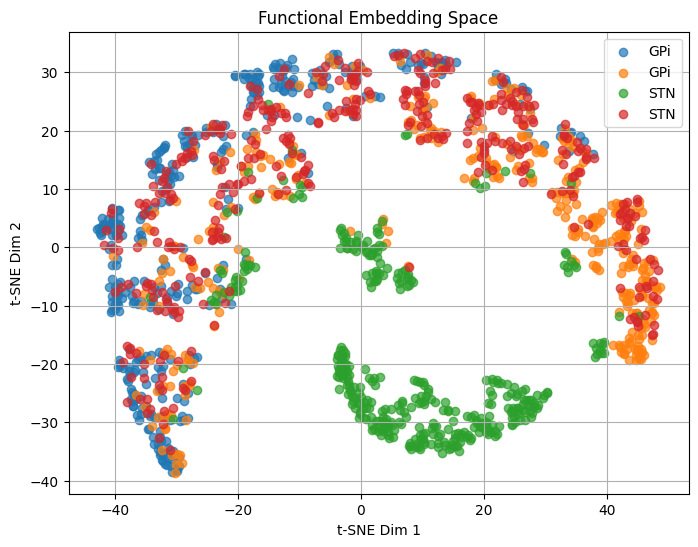

In [57]:
# visualize_embeddings.py


# model = SiameseNet(embedding_dim=EMBEDDING_DIM).to(device)
# model.load_state_dict(torch.load("only weights_siamese_model.pt", map_location=device))
# trained_model= torch.load("runs/siamese_2025-04-30_11-08_lfs_multi_channel/full_siamese_model_best.pt", weights_only=False)
trained_model.eval()
encoder_model = trained_model.encoder
encoder_model.eval()


# laod data
dataPath = get_data_directory()
with h5py.File(dataPath+ "lfs data\\microGPi1_L_4_CommonFiltered_lfs.mat", "r") as f:
    raw_gpi1 = np.array(f["data"]).squeeze()
    fs = int(np.array(f["fs"]).squeeze())
with h5py.File(dataPath+ "lfs data\\microGPi1_L_6_CommonFiltered_lfs.mat", "r") as f: # \\
    raw_gpi2 = np.array(f["data"]).squeeze()
with h5py.File(dataPath + "lfs data\\microVIM_L_5_CommonFiltered_lfs.mat", "r") as f:
    raw_stn1 = np.array(f["data"]).squeeze()  # replace with your actual filename
with h5py.File(dataPath + "lfs data\\microVIM_L_4_CommonFiltered_lfs.mat", "r") as f:
    raw_stn2 = np.array(f["data"]).squeeze()  # replace with your actual filename

# resample and filter 
# resampled_gpi1 = filter_and_resample(raw_gpi1, original_fs=fs, target_fs=1000, cutoff=500)
# resampled_gpi2 = filter_and_resample(raw_gpi2, original_fs=fs, target_fs=1000, cutoff=500)
# resampled_stn1 = filter_and_resample(raw_stn1, original_fs=fs, target_fs=1000, cutoff=500)
# resampled_stn2 = filter_and_resample(raw_stn2, original_fs=fs, target_fs=1000, cutoff=500)

# normalization 
# gpi_data1 = (resampled_gpi1 - np.mean(resampled_gpi1)) / np.std(resampled_gpi1)
# gpi_data2 = (resampled_gpi2 - np.mean(resampled_gpi2)) / np.std(resampled_gpi2)
# stn_data1 = (resampled_stn1 - np.mean(resampled_stn1)) / np.std(resampled_stn1)
# stn_data2 = (resampled_stn2 - np.mean(resampled_stn2)) / np.std(resampled_stn2)

# normalization 
gpi_data1 = (raw_gpi1 - np.mean(raw_gpi1)) / np.std(raw_gpi1)
gpi_data2 = (raw_gpi2 - np.mean(raw_gpi2)) / np.std(raw_gpi2)
stn_data1 = (raw_stn1 - np.mean(raw_stn1)) / np.std(raw_stn1)
stn_data2 = (raw_stn2 - np.mean(raw_stn2)) / np.std(raw_stn2)

# data segmentation 
gpi_segments1 = segment_data(gpi_data1, SEGMENT_LENGTH, shuffle=False)[:1000]  # take first 100 segments\
gpi_segments2 = segment_data(gpi_data2, SEGMENT_LENGTH, shuffle=False)[:1000]  # take first 100 segments
stn_segments1 = segment_data(stn_data1, SEGMENT_LENGTH, shuffle=False)[:1000]
stn_segments2 = segment_data(stn_data2, SEGMENT_LENGTH, shuffle=False)[:1000]

gpi_embeddings1 = extract_embeddings(encoder_model, gpi_segments1, label=0, device=device)
gpi_embeddings2 = extract_embeddings(encoder_model, gpi_segments2, label=1, device=device)
stn_embeddings1 = extract_embeddings(encoder_model, stn_segments1, label=3, device=device)
stn_embeddings2 = extract_embeddings(encoder_model, stn_segments2, label=4, device=device)

all_embeddings = gpi_embeddings1 + gpi_embeddings2+stn_embeddings1+stn_embeddings2
 # 'correlation' , 'cosine', 'manhattan' (L1 distance good for sparse),  'euclidean' (default)
visualize(all_embeddings, TSNE_metric='euclidean')

In [ ]:
print(all_embeddings[0][1])


0


f:\Python Projects\NIPS2025\venv311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
f:\Python Projects\NIPS2025\venv311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


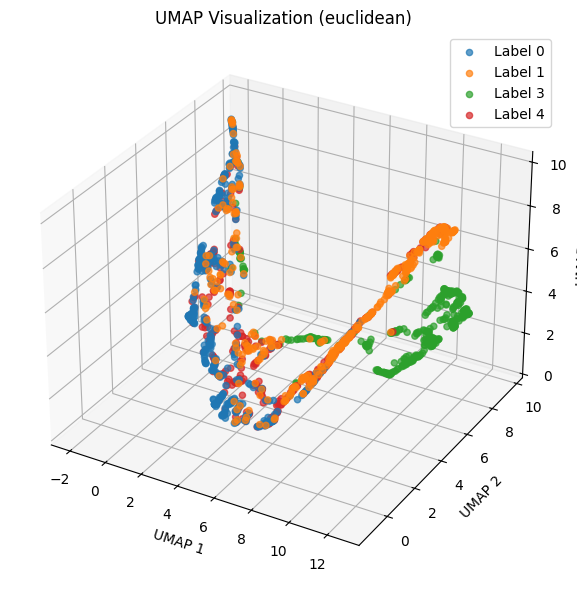

In [59]:
# visualize_distance_heatmap(all_embeddings)
embeddings = np.array([e for e, _ in all_embeddings])
labels = np.array([l for _, l in all_embeddings])
visualize_embeddings(embeddings, labels, method="umap", metric="euclidean", mode="3d")


In [ ]:
def visualize3d(embeddings_with_labels):
    embeddings = np.array([e for e, _ in embeddings_with_labels])
    labels = np.array([l for _, l in embeddings_with_labels])

    tsne = TSNE(n_components=3, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot()#projection='3d')
    for label in np.unique(labels):
        idx = labels == label
        ax.scatter(reduced[idx, 1], reduced[idx, 2], label=f"{'GPi' if label < 2 else 'STN'}", alpha=0.7)

    plt.legend()
    plt.title("Functional Embedding Space")
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    # ax.set_zlabel('Z Label')
    plt.grid(True)
    plt.show()

In [ ]:
visualize3d(all_embeddings)

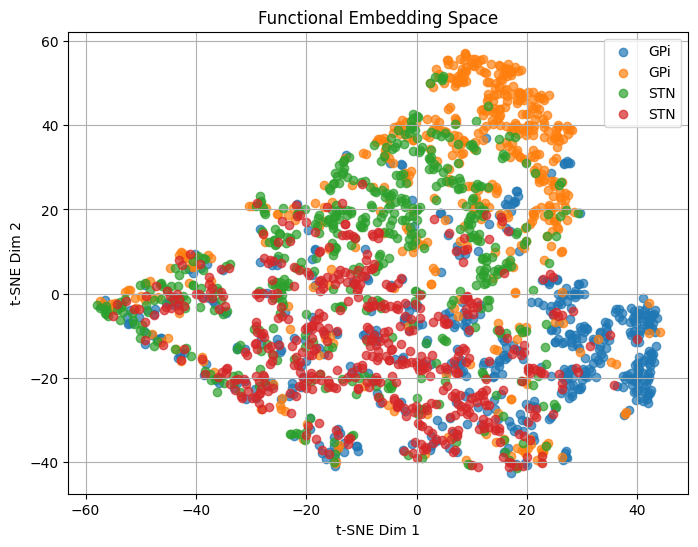

In [181]:
# visualize_embeddings.py


# model = SiameseNet(embedding_dim=EMBEDDING_DIM).to(device)
# model.load_state_dict(torch.load("only weights_siamese_model.pt", map_location=device))
trained_model= torch.load("runs/siamese_2025-04-23_01-03multi_channel/full_siamese_model_best.pt", weights_only=False)
trained_model.eval()
encoder_model = trained_model.encoder
encoder_model.eval()

dataPath = get_data_directory()
with h5py.File(dataPath+ "microGPi1_L_4_CommonFiltered.mat", "r") as f:
    raw_gpi1 = np.array(f["data"]).squeeze()
    fs = int(np.array(f["fs"]).squeeze())
with h5py.File(dataPath+ "microGPi1_L_6_CommonFiltered.mat", "r") as f:
    raw_gpi2 = np.array(f["data"]).squeeze()
with h5py.File(dataPath + "microSTN_L_3_CommonFiltered.mat", "r") as f:
    raw_stn1 = np.array(f["data"]).squeeze()  # replace with your actual filename
with h5py.File(dataPath + "microSTN_L_1_CommonFiltered.mat", "r") as f:
    raw_stn2 = np.array(f["data"]).squeeze()  # replace with your actual filename

# normalization 
gpi_data1 = (raw_gpi1 - np.mean(raw_gpi1)) / np.std(raw_gpi1)
gpi_data2 = (raw_gpi2 - np.mean(raw_gpi2)) / np.std(raw_gpi2)

stn_data1 = (raw_stn1 - np.mean(raw_stn1)) / np.std(raw_stn1)
stn_data2 = (raw_stn2 - np.mean(raw_stn2)) / np.std(raw_stn2)


gpi_segments1 = segment_data(gpi_data1, SEGMENT_LENGTH, shuffle=False)[:500]  # take first 100 segments\
gpi_segments2 = segment_data(gpi_data2, SEGMENT_LENGTH, shuffle=False)[:500]  # take first 100 segments
stn_segments1 = segment_data(stn_data1, SEGMENT_LENGTH, shuffle=False)[:500]
stn_segments2 = segment_data(stn_data2, SEGMENT_LENGTH, shuffle=False)[:500]

gpi_embeddings1 = extract_embeddings(encoder_model, gpi_segments1, label=0, device=device)
gpi_embeddings2 = extract_embeddings(encoder_model, gpi_segments2, label=1, device=device)
stn_embeddings1 = extract_embeddings(encoder_model, stn_segments1, label=3, device=device)
stn_embeddings2 = extract_embeddings(encoder_model, stn_segments2, label=4, device=device)

all_embeddings = gpi_embeddings1 + gpi_embeddings2+stn_embeddings1+stn_embeddings2
visualize(all_embeddings)




In [156]:
gpi_segments1.shape
a = np.concatenate([gpi_segments1,gpi_segments1])
a.shape

(1000, 125000)

# To do:

- add sampling for a genral input from many classes
- write the code to visualize in all embeddings 
- clean the codes a bit
- compare a bunch of candiate models and hyper parameters 
- add clustering accuracy for other regions and distance metrics to check generalizability 
- start transformer code starting with predicting future or EMG
- start integrating over multiple sessions and multiple days and multiple subjects
- look at explainable ai and its technic to see what features it learns to segregate regions, maybe add a generative part to see what it generates, or give it different characteristic inputs to see which one it is sesetive to (different frq bands)
- start to see how these locations can be used for the paper (comparison of multi day embeddings or multi subject, or left or right)

Done:
- when getting segments add an option for shuffeling so theat when testing you dont wnat to shuffle so ypu have an idea of its time
- add new visualization since tnse is wierd or add other tnse metrics: already did so test it and also change it such that any label could be coorectly legended(perhaps just give the label name with it)
- add matlab for filtering since its so slow here in python 

In [177]:
a = np.array([[1,2,3],[4,5,6]])
print(a)
np.random.shuffle(a)
print(a)

[[1 2 3]
 [4 5 6]]
[[4 5 6]
 [1 2 3]]


In [ ]:
# # Run
# if __name__ == "__main__":
#     model = main()x
    

===== Dataset Information =====
Balanced similarity label ratio: 0.50 similar (label 0), 0.50 dissimilar (label 1)
Train set: 4736 pairs
Test set: 1184 pairs
Batch size: 16
Running on Real data


===== Training Input Shape Info =====
Train input shapes: x1: torch.Size([16, 1, 125000]), x2: torch.Size([16, 1, 125000])
===== Testing Input Shape Info =====
Test input shapes: x1: torch.Size([16, 1, 125000]), x2: torch.Size([16, 1, 125000])
 Using cpu
===== Sample Forward Pass Shape Info =====

Model Summary:

SiameseNet(
  (encoder): CNNEncoder(
    (layers): ModuleList(
      (0): Dropout(p=0.3, inplace=False)
      (1): Conv1d(1, 32, kernel_size=(32,), stride=(8,))
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(32, 64, kernel_size=(32,), stride=(2,))
      (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): 

f:\Python Projects\NIPS2025\utils.py:20: RuntimeWarning: ⚠️ CUDA is not available. The model will run on CPU, which may be slower.
  warnings.warn("⚠️ CUDA is not available. The model will run on CPU, which may be slower.", RuntimeWarning)


Train Preds: tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
Train Labels: tensor([0., 0., 0., 0., 0., 0., 1., 1., 0., 1.])
Epoch 1 Train Accuracy: 0.5239
Test Preds: tensor([0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.])
Test Labels: tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.])
Epoch 1 Test Accuracy: 0.8066
Epoch 1 - LR: 0.001000 - Train Loss: 0.2946 - Test Loss: 0.3603
Train Preds: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])
Train Labels: tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 1.])
Epoch 2 Train Accuracy: 0.5416
Test Preds: tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.])
Test Labels: tensor([0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.])
Epoch 2 Test Accuracy: 0.6242
Epoch 2 - LR: 0.001000 - Train Loss: 0.2872 - Test Loss: 0.4634
Train Preds: tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])
Train Labels: tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
Epoch 3 Train Accuracy: 0.5598
Test Preds: tensor

KeyboardInterrupt: 

In [ ]:
# Run
if __name__ == "__main__":
    model = main()

===== Dataset Information =====
Balanced similarity label ratio: 0.50 similar (label 0), 0.50 dissimilar (label 1)
Train set: 1185 pairs
Test set: 297 pairs
Batch size: 16
cpu
===== Sample Forward Pass Shape Info =====

Model Summary:

SiameseNet(
  (encoder): CNNEncoder(
    (layers): ModuleList(
      (0): Dropout(p=0.3, inplace=False)
      (1): Conv1d(1, 32, kernel_size=(32,), stride=(8,))
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.5, inplace=False)
      (5): Conv1d(32, 64, kernel_size=(32,), stride=(2,))
      (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): Dropout(p=0.5, inplace=False)
      (9): Conv1d(64, 64, kernel_size=(16,), stride=(2,))
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): Dropout(p=0.5, inplace=False)
      (13): Conv1d(64, 64, kernel_

In [ ]:
# to do: 
# add more dense layers maybe it can help with non linearity of the map add 3 fully connected layers
# learning rate scheduler